# SDN-DNN with NSL-KDD

This notebook applies the DNN proposed by Tang et al. in [10.1109/WINCOM.2016.7777224](https://doi.org/10.1109/WINCOM.2016.7777224) on the NSL-KDD dataset.  
The NSL-KDD version used is the [preprocessed one by the University of New Brunswick, Canada](http://www.unb.ca/cic/datasets/nsl.html).

In [1]:
from datetime import datetime
import json
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

## Data loading and prep

As we've pickled the normalized and encoded dataset, we only need to load these pickles to get the Pandas DataFrames back.  
Hint: If you miss the pickles, go ahead and run the notebook named Pickle-NSL-KDD-ipynb

In [2]:
def load_df(filename):
    filepath = os.path.join('NSL_KDD', filename+'.pkl')
    return pd.read_pickle(filepath)

In [3]:
kdd_train_data = load_df('kdd_train_data')
kdd_test_data = load_df('kdd_test_data')
kdd_train_labels = load_df('kdd_train_labels')
kdd_test_labels = load_df('kdd_test_labels')

In [4]:
kdd_train_data.tail()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type,service,flag
125968,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.360078,0.048924,1.0,1.0,0.0,0.0,0.14,0.06,0.0,1.0,0.098039,0.10,0.06,0.00,0.0,1.00,1.0,0.00,0.0,0.0,0.028986,0.1
125969,0.000186,7.608895e-08,1.106923e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.0,0.956863,0.96,0.01,0.01,0.0,0.00,0.0,0.00,0.0,0.5,0.028986,0.0
125970,0.000000,1.616709e-06,2.931438e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.0,0.117647,0.12,0.06,0.00,0.0,0.72,0.0,0.01,0.0,0.0,0.217391,0.0
125971,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.281800,0.015656,1.0,1.0,0.0,0.0,0.06,0.05,0.0,1.0,0.031373,0.03,0.05,0.00,0.0,1.00,1.0,0.00,0.0,0.0,0.507246,0.1
125972,0.000000,1.094232e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.00,0.00,0.0,1.0,0.301961,0.30,0.03,0.30,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0


The paper mentions that they only use six features of the full dataset which is why we filter the dataframes for these.

In [5]:
# only keep columns that are actually used
used_fields = ['duration', 'protocol_type', 'src_bytes', 'dst_bytes', 'count', 'srv_count']
kdd_train_data = kdd_train_data.filter(used_fields)
kdd_test_data = kdd_test_data.filter(used_fields)
kdd_train_data.tail()

,duration,protocol_type,src_bytes,dst_bytes,count,srv_count
125968,0.000000,0.0,0.000000e+00,0.000000e+00,0.360078,0.048924
125969,0.000186,0.5,7.608895e-08,1.106923e-07,0.003914,0.003914
125970,0.000000,0.0,1.616709e-06,2.931438e-07,0.001957,0.001957
125971,0.000000,0.0,0.000000e+00,0.000000e+00,0.281800,0.015656
125972,0.000000,0.0,1.094232e-07,0.000000e+00,0.001957,0.001957


## Label Translation

As we are doing binary classification, we only need to know if the entry is normal/benign (0) or malicious (1)

In [6]:
# Load the translation data from the Keras Tokenizer
with open(os.path.join('NSL_KDD','kdd_label_wordindex.json')) as json_in:
    data = json.load(json_in)
    print(data)
    normal_index = data['normal']

{'normal': 1, 'neptune': 2, 'warezclient': 3, 'ipsweep': 4, 'portsweep': 5, 'teardrop': 6, 'nmap': 7, 'satan': 8, 'smurf': 9, 'pod': 10, 'back': 11, 'guess_passwd': 12, 'ftp_write': 13, 'multihop': 14, 'rootkit': 15, 'buffer_overflow': 16, 'imap': 17, 'warezmaster': 18, 'phf': 19, 'land': 20, 'loadmodule': 21, 'spy': 22, 'perl': 23, 'saint': 24, 'mscan': 25, 'apache2': 26, 'snmpgetattack': 27, 'processtable': 28, 'httptunnel': 29, 'ps': 30, 'snmpguess': 31, 'mailbomb': 32, 'named': 33, 'sendmail': 34, 'xterm': 35, 'worm': 36, 'xlock': 37, 'xsnoop': 38, 'sqlattack': 39, 'udpstorm': 40}


In [7]:
def f(x):
    return 0 if x == normal_index else 1
f = np.vectorize(f)

In [8]:
kdd_train_labels.head()

,label,difficulty_level,label_encoded
0,normal,20,1
1,normal,15,1
2,neptune,19,2
3,normal,21,1
4,normal,21,1


In [9]:
# We only want to know if it's benign or not, so we switch to 0 or 1
kdd_train_labels = f(kdd_train_labels['label_encoded'].values)
kdd_test_labels = f(kdd_test_labels['label_encoded'].values)

In [10]:
kdd_train_labels[:5]

array([0, 0, 1, 0, 0])

In [11]:
print("No of train entries:\t", len(kdd_train_data))
print("No of train labels:\t", len(kdd_train_labels))
print("-----------")
print("No of test entries:\t", len(kdd_test_data))
print("No of test labels:\t", len(kdd_test_labels))

No of train entries:	 125973
No of train labels:	 125973
-----------
No of test entries:	 22543
No of test labels:	 22543


## Runtime Preqs

These are the main vars used in the model run

In [12]:
batch_size = 10
epochs     = 10
learn_rate = 0.001

In [13]:
run_date = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
runtype_name = 'nsl-kdd-sdn-dnn'
log_folder_path = os.path.join('logs',runtype_name + '-{}'.format(run_date))

print('Using set globals: ')
print('Batch Size:\t', batch_size)
print('Epochs:\t\t', epochs)
print('Learn rate:\t', learn_rate)

Using set globals: 
Batch Size:	 10
Epochs:		 10
Learn rate:	 0.001


In [14]:
print("No of scaled train entries:\t", len(kdd_train_data))
print("No of train labels:\t\t", len(kdd_train_labels))
print("-----------")
print("No of test entries:\t\t", len(kdd_test_data))
print("No of test labels:\t\t", len(kdd_test_labels))

No of scaled train entries:	 125973
No of train labels:		 125973
-----------
No of test entries:		 22543
No of test labels:		 22543


## Building and Training the Model

In [15]:
# Time for some nice vizualization stuff. Set this up and include as callback, then:
# tensorboard --logdir=path/to/logdir
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard

callbacks = [
    ModelCheckpoint(
        filepath='models/'+runtype_name+'-{}.h5'.format(run_date),
        monitor='val_loss',   
        save_best_only=True    # Only save one. Only overwrite this one if val_loss has improved
    ),
    TensorBoard(
        log_dir=log_folder_path,
        #histogram_freq=1,     # Record activation histograms every epoch
        #embeddings_freq=1,     # Record embedding data every epoch -> There's something wrong with the embeddings here. Keras crashed with them enabled
        #embeddings_layer_names=['LSTMnet'],
        #embeddings_metadata='metadata.tsv',
        #embeddings_data=data_test,
       # batch_size=batch_size
    )
]

Using TensorFlow backend.


In [16]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import RMSprop
from keras.utils import plot_model

# see implementation/sdn-dnn.py for details, alternatives and comments
# TODO: Isn't there some kind of dropout missing?

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=6))
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(RMSprop(lr=learn_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(kdd_train_data, kdd_train_labels, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=(kdd_test_data, kdd_test_labels),
                    callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                84        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 8         
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________
Train on 125973 samples, validate on 22543 samples
Epoch 1/10
125973/125973 [==============================] - 11s 84us/step - loss: 0.2435 - acc: 0.9100 - val_loss: 0.7466 - val_acc: 0.7078
Epoch 2/10
125973/125973 [==============================] - 12s 96us/step - loss: 0.1

In [45]:
# https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
from sklearn.metrics import roc_curve
y_pred = model.predict(kdd_test_data)
y_pred = np.argmax(y_pred, axis=1)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(kdd_test_labels, y_pred)

In [46]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

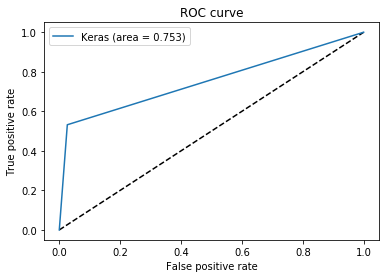

In [50]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [55]:
# https://medium.com/@pushkarmandot/build-your-first-deep-learning-neural-network-model-using-keras-in-python-a90b5864116d
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(kdd_test_labels, y_pred)
print(cm)

[[9454  256]
 [6006 6827]]


Confusion matrix, without normalization
[[9454  256]
 [6006 6827]]
Normalized confusion matrix
[[0.97 0.03]
 [0.47 0.53]]


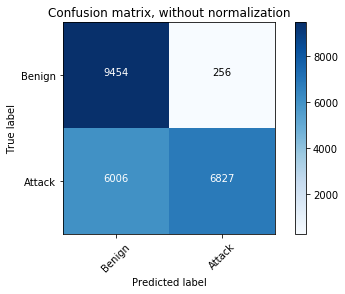

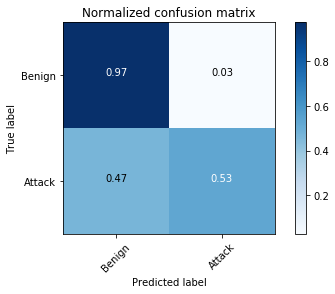

In [59]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools 

class_names=['Benign','Attack']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cnf_matrix = confusion_matrix(kdd_test_labels, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [64]:
# https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case
from sklearn.metrics import f1_score

print(f1_score(kdd_test_labels, y_pred, average="macro"))

0.7183955968264966


In [60]:
filepath='models/'+runtype_name+'-{}_final.h5'.format(run_date)

model.save(filepath)  